In [10]:
# for structure_m in ['Amb_L', 'Amb_R', ('3N_L', '4N_L'), ('3N_R', '4N_R'), '5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', '10N_L', '10N_R', '12N']:

for stack in ['CHATM2', 'CHATM3']:
# for stack in ['MD661']:

#     for structure_m in ['Amb_L', 'Amb_R', ('3N_L', '4N_L'), ('3N_R', '4N_R'), '5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', '10N_L', '10N_R', '12N']:
#     for structure_m in [('3N_L', '4N_L'), ('3N_R', '4N_R')]:
#     for structure_m in [('SC', 'IC')]:
    for structure_m in motor_nuclei_sided_sorted_by_rostral_caudal_position:
    
        T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol = \
        bp.unpack_ndarray_file('/home/yuncong/' + stack + '_T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol.bp')

        init_T = T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol
       

        stack_m_spec = dict(name='atlasV6',
                   vol_type='score',
                   structure=structure_m,
                    resolution='10.0um'
                   )

        stack_f_spec = dict(name=stack,
                           vol_type='score',
                           detector_id=799,
                           structure=convert_to_original_name(structure_m),
                            resolution='10.0um'
                           )

        simpleGlobal_alignment_spec = dict(stack_m=stack_m_spec, 
                              stack_f=stack_f_spec,
                              warp_setting=0)

        atlas_structure_wrt_canonicalAtlasSpace_atlasResol = \
        DataManager.load_original_volume_v2(stack_spec=stack_m_spec, bbox_wrt='canonicalAtlasSpace', structure=structure_m)

        aligned_structure_wrt_wholebrain_inputResol = \
        transform_volume_v4(volume=atlas_structure_wrt_canonicalAtlasSpace_atlasResol,
                            transform=init_T,
                            return_origin_instead_of_bbox=True)

        DataManager.save_transformed_volume_v2(volume=aligned_structure_wrt_wholebrain_inputResol, 
                                               alignment_spec=simpleGlobal_alignment_spec)

Interpolating/filling sparse volume: 0.01 seconds.
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV6/atlasV6_10.0um_scoreVolume_3N_R_warp0_CHATM2_detector799_10.0um_scoreVolume_3N_10.0um/score_volumes/atlasV6_10.0um_scoreVolume_3N_R_warp0_CHATM2_detector799_10.0um_scoreVolume_3N_10.0um_3N_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV6/atlasV6_10.0um_scoreVolume_3N_R_warp0_CHATM2_detector799_10.0um_scoreVolume_3N_10.0um/score_volumes/atlasV6_10.0um_scoreVolume_3N_R_warp0_CHATM2_detector799_10.0um_scoreVolume_3N_10.0um_3N_R.bp"
return code: 0
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV6/atlasV6_10.0um_scoreVolume_3N_R_warp0_CHATM2_detector799_10.0um_scoreVolume_3N_10.0um/score_volumes/atlasV6_10.0um_scoreVolume_3N_R_warp0_CHATM2_detector799_10.0um_scoreVolume_3N_10.0um_3N_R_origin_wrt_fixedWholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV6/atlasV6_10.0um_scoreVolume_3N_R_warp0_CHATM2_detector799_10.0um_scoreVolume_3N_10.0um/score_volumes/atlasV6_10.0um_scoreVolume_3N_R_w

return code: 0
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV6/atlasV6_10.0um_scoreVolume_6N_L_warp0_CHATM2_detector799_10.0um_scoreVolume_6N_10.0um/score_volumes/atlasV6_10.0um_scoreVolume_6N_L_warp0_CHATM2_detector799_10.0um_scoreVolume_6N_10.0um_6N_L_origin_wrt_fixedWholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV6/atlasV6_10.0um_scoreVolume_6N_L_warp0_CHATM2_detector799_10.0um_scoreVolume_6N_10.0um/score_volumes/atlasV6_10.0um_scoreVolume_6N_L_warp0_CHATM2_detector799_10.0um_scoreVolume_6N_10.0um_6N_L_origin_wrt_fixedWholebrain.txt"
return code: 0
Interpolating/filling sparse volume: 0.06 seconds.
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV6/atlasV6_10.0um_scoreVolume_7N_R_warp0_CHATM2_detector799_10.0um_scoreVolume_7N_10.0um/score_volumes/atlasV6_10.0um_scoreVolume_7N_R_warp0_CHATM2_detector799_10.0um_scoreVolume_7N_10.0um_7N_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV6/atlasV6_10.0um_scoreVolume_7N_R_warp0_CHATM2_detector799_10.0um_scoreVolume_7N_10.0um/scor

return code: 0
Interpolating/filling sparse volume: 0.01 seconds.
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV6/atlasV6_10.0um_scoreVolume_3N_R_warp0_CHATM3_detector799_10.0um_scoreVolume_3N_10.0um/score_volumes/atlasV6_10.0um_scoreVolume_3N_R_warp0_CHATM3_detector799_10.0um_scoreVolume_3N_10.0um_3N_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV6/atlasV6_10.0um_scoreVolume_3N_R_warp0_CHATM3_detector799_10.0um_scoreVolume_3N_10.0um/score_volumes/atlasV6_10.0um_scoreVolume_3N_R_warp0_CHATM3_detector799_10.0um_scoreVolume_3N_10.0um_3N_R.bp"
return code: 0
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV6/atlasV6_10.0um_scoreVolume_3N_R_warp0_CHATM3_detector799_10.0um_scoreVolume_3N_10.0um/score_volumes/atlasV6_10.0um_scoreVolume_3N_R_warp0_CHATM3_detector799_10.0um_scoreVolume_3N_10.0um_3N_R_origin_wrt_fixedWholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV6/atlasV6_10.0um_scoreVolume_3N_R_warp0_CHATM3_detector799_10.0um_scoreVolume_3N_10.0um/score_volumes/atlasV6_10.0um_sco

return code: 0
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV6/atlasV6_10.0um_scoreVolume_6N_L_warp0_CHATM3_detector799_10.0um_scoreVolume_6N_10.0um/score_volumes/atlasV6_10.0um_scoreVolume_6N_L_warp0_CHATM3_detector799_10.0um_scoreVolume_6N_10.0um_6N_L_origin_wrt_fixedWholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV6/atlasV6_10.0um_scoreVolume_6N_L_warp0_CHATM3_detector799_10.0um_scoreVolume_6N_10.0um/score_volumes/atlasV6_10.0um_scoreVolume_6N_L_warp0_CHATM3_detector799_10.0um_scoreVolume_6N_10.0um_6N_L_origin_wrt_fixedWholebrain.txt"
return code: 0
Interpolating/filling sparse volume: 0.06 seconds.
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV6/atlasV6_10.0um_scoreVolume_7N_R_warp0_CHATM3_detector799_10.0um_scoreVolume_7N_10.0um/score_volumes/atlasV6_10.0um_scoreVolume_7N_R_warp0_CHATM3_detector799_10.0um_scoreVolume_7N_10.0um_7N_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV6/atlasV6_10.0um_scoreVolume_7N_R_warp0_CHATM3_detector799_10.0um_scoreVolume_7N_10.0um/scor

return code: 0


In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

Setting environment for Precision WorkStation


No vtk


In [2]:
from aligner_v3 import Aligner

In [3]:
# stack = 'CHATM2'
# stack = 'CHATM3'

In [6]:
# detector_id = 19
detector_id = 799

In [5]:
warp_setting = 7

upstream_warp_id                                                               None
transform_type                                                                rigid
grad_computation_sample_number                                               100000
grid_search_sample_number                                                      1000
std_tx_um                                                                        50
std_ty_um                                                                        50
std_tz_um                                                                        50
std_theta_xy_degree                                                              10
surround_weight                                                             inverse
regularization_weight                                                           NaN
terminate_thresh_trans                                                         0.01
terminate_thresh_rot                                                        

Prior structure/index map not found. Generating a new one.
Loaded moving volumes: ['Amb_L', 'Amb_L_surround_200um'].
Prior structure/index map not found. Generating a new one.
Loaded fixed volumes: ['Amb_L'].
Computing structure sizes: 0.00 s
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


voxel size for moving = 10.00 um
voxel size for fixed = 10.00 um
label_mapping_m2f {1: 1, 2: 1}
{1: -0.029241352751715445, 2: 1.0}


indices_f: set([1])
Set initial transform to [ 9.71736748e-01  2.36076991e-01  0.00000000e+00  1.06809838e+03
 -2.36076991e-01  9.71736748e-01  0.00000000e+00  5.57968802e+02
  0.00000000e+00  0.00000000e+00  1.00000000e+00  4.48000000e+02].
centroid_m: [1202.53821194  631.76545473  325.29949162], centroid_f: [1202.53821194  631.76545473  325.29949162]
sigma_tx: 100.00 (voxel), sigma_ty: 100.00, sigma_tz: 30.00, sigma_theta_xy: 30.00 (deg), n:10
1: 0 valid, 114256 out-of-bound voxels after transform.
2: 3514 valid, 21890 out-of-bound voxels after transform.
1: 11374 valid, 102882 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
1: 16500 valid, 97756 out-of-bound voxels after transform.
2: 0 valid, 25404 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
1: 16500 valid, 97756 out-of-bound voxels after transform.
1: 16500 valid, 97756 out-of-bound voxels after transform.
2: 6233 valid,

2: 6233 valid, 19171 out-of-bound voxels after transform.
2: 582 valid, 24822 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
2: 0 valid, 25404 out-of-bound voxels after transform.
2: 0 valid, 25404 out-of-bound voxels after transform.
2: 14787 valid, 10617 out-of-bound voxels after transform.
2: 6233 valid, 19171 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
1: 16500 valid, 97756 out-of-bound voxels after transform.
1: 13687 valid, 100569 out-of-bound voxels after transform.
2: 14787 valid, 10617 out-of-bound voxels after transform.
1: 11374 valid, 102882 out-of-bound voxels after transform.
1: 59315 valid, 54941 out-of-bound voxels after transform.
1: 16500 valid, 97756 out-of-bound voxels after transform.
2: 23307 valid, 2097 out-of-bound voxels after transform.
2: 6233 valid, 19171 out-of-bound voxels after tr

Error computing score for 2: 2: No valid voxels after transform.
1: 59315 valid, 54941 out-of-bound voxels after transform.
2: 14787 valid, 10617 out-of-bound voxels after transform.
1: 59315 valid, 54941 out-of-bound voxels after transform.
2: 6233 valid, 19171 out-of-bound voxels after transform.
1: 16500 valid, 97756 out-of-bound voxels after transform.
1: 905 valid, 113351 out-of-bound voxels after transform.
2: 6233 valid, 19171 out-of-bound voxels after transform.
1: 66030 valid, 48226 out-of-bound voxels after transform.
1: 59315 valid, 54941 out-of-bound voxels after transform.
1: 16500 valid, 97756 out-of-bound voxels after transform.
2: 0 valid, 25404 out-of-bound voxels after transform.
1: 59315 valid, 54941 out-of-bound voxels after transform.
1: 6900 valid, 107356 out-of-bound voxels after transform.
1: 16500 valid, 97756 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
2: 23307 valid, 2097 out-of-bound voxels after tran

Error computing score for 2: 2: No valid voxels after transform.
1: 66030 valid, 48226 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
2: 14787 valid, 10617 out-of-bound voxels after transform.
2: 0 valid, 25404 out-of-bound voxels after transform.
2: 6233 valid, 19171 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
2: 14787 valid, 10617 out-of-bound voxels after transform.
2: 9212 valid, 16192 out-of-bound voxels after transform.
1: 102523 valid, 11733 out-of-bound voxels after transform.
1: 905 valid, 113351 out-of-bound voxels after transform.
1: 16500 valid, 97756 out-of-bound voxels after transform.
1: 16500 valid, 97756 out-of-bound voxels after transform.
2: 0 valid, 25404 out-of-bound voxels after transform.
2: 14787 valid, 10617 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid v

2: 23307 valid, 2097 out-of-bound voxels after transform.
2: 9212 valid, 16192 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
2: 14787 valid, 10617 out-of-bound voxels after transform.
1: 102523 valid, 11733 out-of-bound voxels after transform.
1: 59315 valid, 54941 out-of-bound voxels after transform.
2: 23307 valid, 2097 out-of-bound voxels after transform.
2: 14787 valid, 10617 out-of-bound voxels after transform.
1: 14410 valid, 99846 out-of-bound voxels after transform.
2: 0 valid, 25404 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
1: 66030 valid, 48226 out-of-bound voxels after transform.
1: 102523 valid, 11733 out-of-bound voxels after transform.
2: 14787 valid, 10617 out-of-bound voxels after transform.
1: 102523 valid, 11733 out-of-bound voxels after transform.
1: 59315 valid, 54941 out-of-bound voxels after transform.
2: 23307 valid, 2097 out-of-bound voxels after t

2: 23307 valid, 2097 out-of-bound voxels after transform.
1: 102523 valid, 11733 out-of-bound voxels after transform.
2: 18583 valid, 6821 out-of-bound voxels after transform.
1: 0 valid, 114256 out-of-bound voxels after transform.
1: 75084 valid, 39172 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
2: 0 valid, 25404 out-of-bound voxels after transform.
1: 0 valid, 114256 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
1: 102523 valid, 11733 out-of-bound voxels after transform.
2: 23307 valid, 2097 out-of-bound voxels after transform.
1: 75084 valid, 39172 out-of-bound voxels after transform.
2: 0 valid, 25404 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
2: 23307 valid, 2097 out-of-bound voxels after transform.
2: 18583 valid, 6821 out-of-bound voxels after t

1: 0 valid, 114256 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
1: 14410 valid, 99846 out-of-bound voxels after transform.
2: 0 valid, 25404 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
2: 23307 valid, 2097 out-of-bound voxels after transform.
2: 663 valid, 24741 out-of-bound voxels after transform.
1: 0 valid, 114256 out-of-bound voxels after transform.
1: 14410 valid, 99846 out-of-bound voxels after transform.
1: 75084 valid, 39172 out-of-bound voxels after transform.
2: 23307 valid, 2097 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
2: 663 valid, 24741 out-of-bound voxels after transform.
2: 18583 valid, 6821 out-of-bound voxels after transform.
2: 0 valid, 25404 out-of-bound voxels after transform.
1: 102523 valid, 11733 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after tran

1: 75084 valid, 39172 out-of-bound voxels after transform.
1: 75084 valid, 39172 out-of-bound voxels after transform.
2: 18583 valid, 6821 out-of-bound voxels after transform.
1: 0 valid, 114256 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
2: 0 valid, 25404 out-of-bound voxels after transform.
2: 18583 valid, 6821 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
1: 75084 valid, 39172 out-of-bound voxels after transform.
1: 75084 valid, 39172 out-of-bound voxels after transform.
1: 0 valid, 114256 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
2: 0 valid, 25404 out-of-bound voxels after transform.
2: 18583 valid, 6821 out-of-bound voxels after transform.
1: 0 valid, 114256 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
2: 18583 valid, 6821 out-of-bound voxels after trans

2: 663 valid, 24741 out-of-bound voxels after transform.
1: 0 valid, 114256 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
2: 18583 valid, 6821 out-of-bound voxels after transform.
2: 0 valid, 25404 out-of-bound voxels after transform.
1: 14410 valid, 99846 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
1: 75084 valid, 39172 out-of-bound voxels after transform.
2: 663 valid, 24741 out-of-bound voxels after transform.
1: 0 valid, 114256 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
2: 18583 valid, 6821 out-of-bound voxels after transform.
2: 0 valid, 25404 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
1: 14410 valid, 99846 out-of-bound voxels after transform.
1: 75084 valid, 39172 out-of-bound voxels after transform.
2: 663 valid, 24741 out-of-bound voxels after transf

1: 91614 valid, 22642 out-of-bound voxels after transform.
1: 111595 valid, 2661 out-of-bound voxels after transform.
1: 93835 valid, 20421 out-of-bound voxels after transform.
1: 93835 valid, 20421 out-of-bound voxels after transform.
1: 93835 valid, 20421 out-of-bound voxels after transform.
1: 113828 valid, 428 out-of-bound voxels after transform.
1: 93835 valid, 20421 out-of-bound voxels after transform.
2: 21395 valid, 4009 out-of-bound voxels after transform.
2: 21395 valid, 4009 out-of-bound voxels after transform.
1: 113828 valid, 428 out-of-bound voxels after transform.
2: 21395 valid, 4009 out-of-bound voxels after transform.
2: 21395 valid, 4009 out-of-bound voxels after transform.
2: 21395 valid, 4009 out-of-bound voxels after transform.
1: 93835 valid, 20421 out-of-bound voxels after transform.
1: 91614 valid, 22642 out-of-bound voxels after transform.
1: 113828 valid, 428 out-of-bound voxels after transform.
1: 93835 valid, 20421 out-of-bound voxels after transform.
1: 93

2: 21395 valid, 4009 out-of-bound voxels after transform.
1: 93835 valid, 20421 out-of-bound voxels after transform.
1: 93835 valid, 20421 out-of-bound voxels after transform.
2: 21395 valid, 4009 out-of-bound voxels after transform.
2: 21395 valid, 4009 out-of-bound voxels after transform.
1: 113828 valid, 428 out-of-bound voxels after transform.
2: 21395 valid, 4009 out-of-bound voxels after transform.
2: 21395 valid, 4009 out-of-bound voxels after transform.
1: 113828 valid, 428 out-of-bound voxels after transform.
1: 113828 valid, 428 out-of-bound voxels after transform.
2: 21395 valid, 4009 out-of-bound voxels after transform.
1: 113828 valid, 428 out-of-bound voxels after transform.
1: 93835 valid, 20421 out-of-bound voxels after transform.
1: 93835 valid, 20421 out-of-bound voxels after transform.
1: 113828 valid, 428 out-of-bound voxels after transform.
1: 93835 valid, 20421 out-of-bound voxels after transform.
1: 93835 valid, 20421 out-of-bound voxels after transform.
1: 93835

2: 21395 valid, 4009 out-of-bound voxels after transform.
1: 113828 valid, 428 out-of-bound voxels after transform.
1: 113828 valid, 428 out-of-bound voxels after transform.
1: 113828 valid, 428 out-of-bound voxels after transform.
1: 93835 valid, 20421 out-of-bound voxels after transform.
1: 93835 valid, 20421 out-of-bound voxels after transform.
1: 93835 valid, 20421 out-of-bound voxels after transform.
1: 111595 valid, 2661 out-of-bound voxels after transform.
1: 113828 valid, 428 out-of-bound voxels after transform.
1: 112023 valid, 2233 out-of-bound voxels after transform.
2: 21395 valid, 4009 out-of-bound voxels after transform.
2: 21395 valid, 4009 out-of-bound voxels after transform.
1: 113828 valid, 428 out-of-bound voxels after transform.
1: 113828 valid, 428 out-of-bound voxels after transform.
2: 21395 valid, 4009 out-of-bound voxels after transform.
1: 111595 valid, 2661 out-of-bound voxels after transform.
1: 112023 valid, 2233 out-of-bound voxels after transform.
1: 9383

Norm of gradient (translation) = 0.405609
Norm of gradient (rotation) = 0.497700
around x=-2.10; around y=-0.16; around z=2.07
step: 0.05 seconds
current score: 0.002168
new_T: [ 9.99342037e-01 -3.60400486e-02 -4.07532751e-03 -2.09057557e+00
  3.61651902e-02  9.98676332e-01  3.65740646e-02  3.60438218e+00
  2.75180206e-03 -3.66973852e-02  9.99322635e-01  4.09094332e-02]
det: 1.00

iteration 7
Norm of gradient (translation) = 0.359955
Norm of gradient (rotation) = 0.362929
around x=-2.21; around y=-0.27; around z=2.21
step: 0.05 seconds
current score: 0.002246
new_T: [ 0.99924306 -0.03840138 -0.00621605 -2.27900699  0.03861182  0.99852028
  0.03829327  3.84343238  0.00473634 -0.03850429  0.99924721  0.22463217]
det: 1.00

iteration 8
Norm of gradient (translation) = 0.357829
Norm of gradient (rotation) = 0.433045
around x=-2.36; around y=-0.12; around z=2.33
step: 0.05 seconds
current score: 0.002243
new_T: [ 9.99170325e-01 -4.05560137e-02 -3.72451431e-03 -2.18270139e+00
  4.06749602e-0

Norm of gradient (translation) = 0.027055
Norm of gradient (rotation) = 0.036554
around x=-3.33; around y=-0.21; around z=3.37
step: 0.05 seconds
current score: 0.002364
new_T: [ 9.98268759e-01 -5.83820808e-02 -7.14264968e-03 -2.89919056e+00
  5.86980595e-02  9.96601853e-01  5.77865420e-02  5.82774126e+00
  3.74467934e-03 -5.81057593e-02  9.98303410e-01 -9.38512612e-03]
det: 1.00

iteration 31
Norm of gradient (translation) = 0.027372
Norm of gradient (rotation) = 0.034369
around x=-3.34; around y=-0.22; around z=3.38
step: 0.05 seconds
current score: 0.002363
new_T: [ 9.98254170e-01 -5.86118715e-02 -7.29800153e-03 -2.90641848e+00
  5.89372730e-02  9.96576098e-01  5.79868846e-02  5.85151581e+00
  3.87429406e-03 -5.83157737e-02  9.98290669e-01 -1.86974268e-04]
det: 1.00

iteration 32
Norm of gradient (translation) = 0.023418
Norm of gradient (rotation) = 0.031070
around x=-3.36; around y=-0.22; around z=3.39
step: 0.05 seconds
current score: 0.002367
new_T: [ 9.98242367e-01 -5.88165060e

Norm of gradient (translation) = 0.002935
Norm of gradient (rotation) = 0.005819
around x=-3.47; around y=-0.26; around z=3.49
step: 0.05 seconds
current score: 0.002363
new_T: [ 9.98132800e-01 -6.05314448e-02 -8.17660548e-03 -2.91635946e+00
  6.09146315e-02  9.96331118e-01  6.01141544e-02  6.05381571e+00
  4.50780986e-03 -6.04999842e-02  9.98158019e-01 -1.73171986e-02]
det: 1.00

iteration 55
Norm of gradient (translation) = 0.002747
Norm of gradient (rotation) = 0.005028
around x=-3.47; around y=-0.26; around z=3.49
step: 0.06 seconds
current score: 0.002363
new_T: [ 9.98131308e-01 -6.05518459e-02 -8.20765168e-03 -2.91569656e+00
  6.09370269e-02  9.96327720e-01  6.01477561e-02  6.05635686e+00
  4.53545323e-03 -6.05355084e-02  9.98155740e-01 -1.79491095e-02]
det: 1.00

iteration 56
Norm of gradient (translation) = 0.002731
Norm of gradient (rotation) = 0.005320
around x=-3.47; around y=-0.26; around z=3.49
step: 0.05 seconds
current score: 0.002363
new_T: [ 9.98129845e-01 -6.05705210e

Norm of gradient (translation) = 0.000234
Norm of gradient (rotation) = 0.003266
around x=-3.50; around y=-0.31; around z=3.50
step: 0.06 seconds
current score: 0.002364
new_T: [ 9.98117229e-01 -6.06659397e-02 -9.03549204e-03 -2.90907184e+00
  6.11031658e-02  9.96293617e-01  6.05428170e-02  6.08002771e+00
  5.32911615e-03 -6.09809259e-02  9.98124705e-01 -1.65704873e-02]
det: 1.00

iteration 79
Norm of gradient (translation) = 0.000487
Norm of gradient (rotation) = 0.003847
around x=-3.50; around y=-0.31; around z=3.50
step: 0.05 seconds
current score: 0.002364
new_T: [ 9.98117181e-01 -6.06611453e-02 -9.07297247e-03 -2.90916351e+00
  6.11007050e-02  9.96293327e-01  6.05500717e-02  6.08008749e+00
  5.36630523e-03 -6.09904318e-02  9.98123925e-01 -1.62519382e-02]
det: 1.00

iteration 80
Norm of gradient (translation) = 0.000427
Norm of gradient (rotation) = 0.003795
around x=-3.50; around y=-0.31; around z=3.50
step: 0.05 seconds
current score: 0.002364
new_T: [ 9.98117138e-01 -6.06563190e

Norm of gradient (translation) = 0.001527
Norm of gradient (rotation) = 0.004671
around x=-3.51; around y=-0.35; around z=3.50
step: 0.05 seconds
current score: 0.002364
new_T: [ 0.99811711 -0.06053798 -0.00986822 -2.9095281   0.06102735  0.9962874
  0.0607214   6.0798596   0.00615563 -0.0612093   0.99810597 -0.01482053]
det: 1.00

iteration 103
Norm of gradient (translation) = 0.001682
Norm of gradient (rotation) = 0.002302
around x=-3.51; around y=-0.35; around z=3.50
step: 0.06 seconds
current score: 0.002364
new_T: [ 0.99811727 -0.06053233 -0.0098874  -2.90841358  0.06102295  0.99628697
  0.06073283  6.07976052  0.00617439 -0.06122184  0.99810509 -0.01622581]
det: 1.00

iteration 104
Norm of gradient (translation) = 0.001123
Norm of gradient (rotation) = 0.004354
around x=-3.51; around y=-0.36; around z=3.50
step: 0.06 seconds
current score: 0.002364
new_T: [ 0.99811717 -0.06052694 -0.00993033 -2.90843029  0.06102023  0.99628683
  0.0607378   6.07980032  0.00621718 -0.06122939  0.9

Norm of gradient (translation) = 0.000282
Norm of gradient (rotation) = 0.003528
around x=-3.52; around y=-0.40; around z=3.49
step: 0.05 seconds
current score: 0.002363
new_T: [ 0.99811684 -0.06040661 -0.01066828 -2.90704203  0.06094647  0.99628134
  0.06090165  6.07931245  0.00694975 -0.06143716  0.99808676 -0.01451989]
det: 1.00

iteration 127
Norm of gradient (translation) = 0.000184
Norm of gradient (rotation) = 0.003459
around x=-3.52; around y=-0.40; around z=3.49
step: 0.05 seconds
current score: 0.002364
new_T: [ 0.99811681 -0.06040129 -0.01070161 -2.90699821  0.06094326  0.99628108
  0.06090922  6.07930418  0.00698282 -0.06144671  0.99808594 -0.01448214]
det: 1.00

iteration 128
Norm of gradient (translation) = 0.000174
Norm of gradient (rotation) = 0.003357
around x=-3.52; around y=-0.40; around z=3.49
step: 0.05 seconds
current score: 0.002364
new_T: [ 0.99811678 -0.06039597 -0.01073381 -2.90682209  0.06093999  0.9962808
  0.06091711  6.07929355  0.00701474 -0.06145651  0.9

Norm of gradient (translation) = 0.000891
Norm of gradient (rotation) = 0.002961
around x=-3.54; around y=-0.44; around z=3.49
step: 0.05 seconds
current score: 0.002362
new_T: [ 0.99811611 -0.06027519 -0.01145156 -2.90681293  0.06086484  0.99627525
  0.06108277  6.07865115  0.00772713 -0.0616647   0.99806701 -0.01461748]
det: 1.00

iteration 151
Norm of gradient (translation) = 0.001838
Norm of gradient (rotation) = 0.004794
around x=-3.54; around y=-0.45; around z=3.49
step: 0.05 seconds
current score: 0.002363
new_T: [ 0.99811589 -0.06026966 -0.01149907 -2.9075537   0.06086228  0.99627521
  0.06108599  6.07868886  0.00777461 -0.06167076  0.99806627 -0.01310116]
det: 1.00

iteration 152
Norm of gradient (translation) = 0.001325
Norm of gradient (rotation) = 0.002755
around x=-3.54; around y=-0.45; around z=3.49
step: 0.05 seconds
current score: 0.002362
new_T: [ 0.99811594 -0.06026404 -0.01152435 -2.90630336  0.06085829  0.99627487
  0.0610954   6.07863894  0.00779957 -0.06168165  0.

Best parameters =
[[ 9.98242367e-01 -5.88165060e-02 -7.26597271e-03 -2.90117562e+00]
 [ 5.91405744e-02  9.96550678e-01  5.82163053e-02  5.87208528e+00]
 [ 3.81683036e-03 -5.85436962e-02  9.98277550e-01 -9.11607374e-03]]
Best score = 0.0023666674884565745 , initial score = 0.001779591202012205


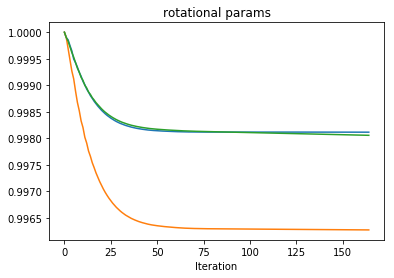

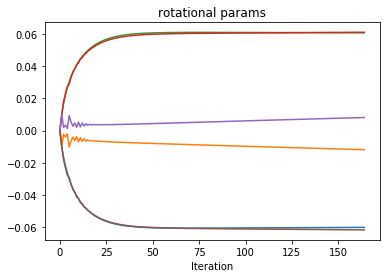

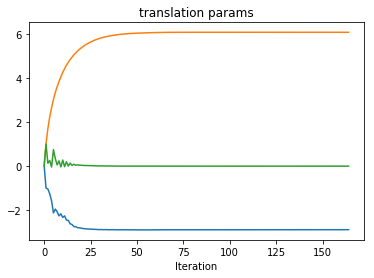

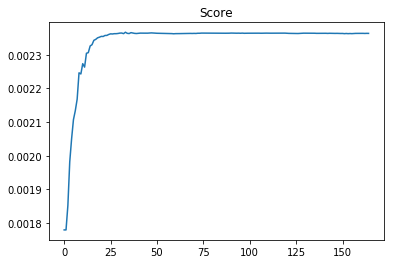

aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV6/atlasV6_10.0um_scoreVolume_Amb_L_warp7_MD661_detector799_10.0um_scoreVolume_Amb/atlasV6_10.0um_scoreVolume_Amb_L_warp7_MD661_detector799_10.0um_scoreVolume_Amb_parameters.json" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV6/atlasV6_10.0um_scoreVolume_Amb_L_warp7_MD661_detector799_10.0um_scoreVolume_Amb/atlasV6_10.0um_scoreVolume_Amb_L_warp7_MD661_detector799_10.0um_scoreVolume_Amb_parameters.json"
return code: 0
aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV6/atlasV6_10.0um_scoreVolume_Amb_L_warp7_MD661_detector799_10.0um_scoreVolume_Amb/atlasV6_10.0um_scoreVolume_Amb_L_warp7_MD661_detector799_10.0um_scoreVolume_Amb_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV6/atlasV6_10.0um_scoreVolume_Amb_L_warp7_MD661_detector799_10.0um_scoreVolume_Amb/atlasV6_10.0um_scoreVolume_Amb_L_warp7_MD661_detector799_10.0um_scoreVolume_Amb_scoreHistory.bp"
return code: 0
aws s3 cp 

upstream_warp_id                                                               None
transform_type                                                                rigid
grad_computation_sample_number                                               100000
grid_search_sample_number                                                      1000
std_tx_um                                                                        50
std_ty_um                                                                        50
std_tz_um                                                                        50
std_theta_xy_degree                                                              10
surround_weight                                                             inverse
regularization_weight                                                           NaN
terminate_thresh_trans                                                         0.01
terminate_thresh_rot                                                        

Loaded fixed volumes: ['Amb_R'].
Computing structure sizes: 0.00 s
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


voxel size for moving = 10.00 um
voxel size for fixed = 10.00 um
label_mapping_m2f {1: 1, 2: 1}
{1: 1.0, 2: -0.029241352751715445}


indices_f: set([1])
Set initial transform to [ 9.71736748e-01  2.36076991e-01  0.00000000e+00  1.06809838e+03
 -2.36076991e-01  9.71736748e-01  0.00000000e+00  5.57968802e+02
  0.00000000e+00  0.00000000e+00  1.00000000e+00  4.48000000e+02].
centroid_m: [1202.53821194  631.76545473  570.70050838], centroid_f: [1202.53821194  631.76545473  570.70050838]
sigma_tx: 100.00 (voxel), sigma_ty: 100.00, sigma_tz: 30.00, sigma_theta_xy: 30.00 (deg), n:10
1: 0 valid, 25404 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
1: 6233 valid, 19171 out-of-bound voxels after transform.
1: 3514 valid, 21890 out-of-bound voxels after transform.
1: 6233 valid, 19171 out-of-bound voxels after transform.
1: 6233 valid, 19171 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
1: 0 valid, 25404 out-of-bound voxels after transform.
1: 9212 valid, 16192 out-of-bound voxels after transform.
2: 16500 valid, 9775

2: 11374 valid, 102882 out-of-bound voxels after transform.
1: 6233 valid, 19171 out-of-bound voxels after transform.
2: 16500 valid, 97756 out-of-bound voxels after transform.
2: 16500 valid, 97756 out-of-bound voxels after transform.
1: 14787 valid, 10617 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
2: 0 valid, 114256 out-of-bound voxels after transform.
1: 14787 valid, 10617 out-of-bound voxels after transform.
1: 582 valid, 24822 out-of-bound voxels after transform.
2: 59315 valid, 54941 out-of-bound voxels after transform.
1: 0 valid, 25404 out-of-bound voxels after transform.
1: 6233 valid, 19171 out-of-bound voxels after transform.
1: 0 valid, 25404 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
1: 6233 valid, 19171 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
1: 3514 valid, 21890 out-of-bound voxels after transf

2: 16500 valid, 97756 out-of-bound voxels after transform.
2: 66030 valid, 48226 out-of-bound voxels after transform.
2: 16500 valid, 97756 out-of-bound voxels after transform.
1: 6233 valid, 19171 out-of-bound voxels after transform.
2: 6900 valid, 107356 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
1: 14787 valid, 10617 out-of-bound voxels after transform.
2: 59315 valid, 54941 out-of-bound voxels after transform.
1: 14787 valid, 10617 out-of-bound voxels after transform.
1: 6233 valid, 19171 out-of-bound voxels after transform.
1: 6233 valid, 19171 out-of-bound voxels after transform.
2: 59315 valid, 54941 out-of-bound voxels after transform.
1: 0 valid, 25404 out-of-bound voxels after transform.
1: 0 valid, 25404 out-of-bound voxels after transform.
1: 6233 valid, 19171 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
Error computing score for 1: 1: No valid voxels after tr

Error computing score for 1: 1: No valid voxels after transform.
2: 59315 valid, 54941 out-of-bound voxels after transform.
1: 6233 valid, 19171 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
2: 0 valid, 114256 out-of-bound voxels after transform.
2: 66030 valid, 48226 out-of-bound voxels after transform.
1: 9212 valid, 16192 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
2: 59315 valid, 54941 out-of-bound voxels after transform.
1: 6233 valid, 19171 out-of-bound voxels after transform.
2: 16500 valid, 97756 out-of-bound voxels after transform.
2: 102523 valid, 11733 out-of-bound voxels after transform.
1: 0 valid, 25404 out-of-bound voxels after transform.
2: 37917 valid, 76339 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
1: 14787 valid, 10617 out-of-bound voxels after transform.
2: 0 valid, 114256 out-of-bound voxels af

1: 23307 valid, 2097 out-of-bound voxels after transform.
1: 14787 valid, 10617 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
1: 23307 valid, 2097 out-of-bound voxels after transform.
1: 23307 valid, 2097 out-of-bound voxels after transform.
2: 59315 valid, 54941 out-of-bound voxels after transform.
1: 23307 valid, 2097 out-of-bound voxels after transform.
1: 14787 valid, 10617 out-of-bound voxels after transform.
2: 14410 valid, 99846 out-of-bound voxels after transform.
1: 23307 valid, 2097 out-of-bound voxels after transform.
2: 102523 valid, 11733 out-of-bound voxels after transform.
2: 0 valid, 114256 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
1: 14787 valid, 10617 out-of-bound voxels after transform.
2: 102523 valid, 11733 out-of-bound voxels after transform.
1: 663 valid, 24741 out-of-bound voxels after transform.
2: 102523 valid, 11733 out-of-bound voxels after tra

2: 102523 valid, 11733 out-of-bound voxels after transform.
1: 18583 valid, 6821 out-of-bound voxels after transform.
1: 0 valid, 25404 out-of-bound voxels after transform.
1: 0 valid, 25404 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
1: 23307 valid, 2097 out-of-bound voxels after transform.
1: 23307 valid, 2097 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
1: 18583 valid, 6821 out-of-bound voxels after transform.
1: 23307 valid, 2097 out-of-bound voxels after transform.
2: 75084 valid, 39172 out-of-bound voxels after transform.
2: 0 valid, 114256 out-of-bound voxels after transform.
2: 0 valid, 114256 out-of-bound voxels after transform.
2: 102523 valid, 11733 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
2: 75084 valid, 39172 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after t

1: 663 valid, 24741 out-of-bound voxels after transform.
2: 102523 valid, 11733 out-of-bound voxels after transform.
2: 102523 valid, 11733 out-of-bound voxels after transform.
2: 0 valid, 114256 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
2: 14410 valid, 99846 out-of-bound voxels after transform.
1: 0 valid, 25404 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
1: 663 valid, 24741 out-of-bound voxels after transform.
1: 23307 valid, 2097 out-of-bound voxels after transform.
1: 23307 valid, 2097 out-of-bound voxels after transform.
2: 0 valid, 114256 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
2: 14410 valid, 99846 out-of-bound voxels after transform.
1: 0 valid, 25404 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
2: 102523 valid, 11733 out-of-bound voxels after t

2: 75084 valid, 39172 out-of-bound voxels after transform.
2: 0 valid, 114256 out-of-bound voxels after transform.
2: 75084 valid, 39172 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
1: 0 valid, 25404 out-of-bound voxels after transform.
1: 18583 valid, 6821 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
1: 18583 valid, 6821 out-of-bound voxels after transform.
2: 0 valid, 114256 out-of-bound voxels after transform.
2: 75084 valid, 39172 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
1: 0 valid, 25404 out-of-bound voxels after transform.
2: 75084 valid, 39172 out-of-bound voxels after transform.
1: 18583 valid, 6821 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
1: 0 valid, 25404 out-of-bound voxels after transform.
1: 18583 valid, 6821 out-of-bound voxels after transf

1: 18583 valid, 6821 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
2: 14410 valid, 99846 out-of-bound voxels after transform.
1: 0 valid, 25404 out-of-bound voxels after transform.
1: 0 valid, 25404 out-of-bound voxels after transform.
2: 75084 valid, 39172 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
Error computing score for 1: 1: No valid voxels after transform.
2: 75084 valid, 39172 out-of-bound voxels after transform.
2: 0 valid, 114256 out-of-bound voxels after transform.
2: 0 valid, 114256 out-of-bound voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
Error computing score for 2: 2: No valid voxels after transform.
1: 0 valid, 25404 out-of-bound voxels after transform.
1: 18583 valid, 6821 out-of-bound voxels after transform.
Error computing score for 1: 1: No valid

1: 21395 valid, 4009 out-of-bound voxels after transform.
1: 21395 valid, 4009 out-of-bound voxels after transform.
1: 21395 valid, 4009 out-of-bound voxels after transform.
1: 21395 valid, 4009 out-of-bound voxels after transform.
1: 21395 valid, 4009 out-of-bound voxels after transform.
2: 93835 valid, 20421 out-of-bound voxels after transform.
2: 111595 valid, 2661 out-of-bound voxels after transform.
2: 91614 valid, 22642 out-of-bound voxels after transform.
2: 93835 valid, 20421 out-of-bound voxels after transform.
2: 93835 valid, 20421 out-of-bound voxels after transform.
2: 93835 valid, 20421 out-of-bound voxels after transform.
2: 113828 valid, 428 out-of-bound voxels after transform.
2: 113828 valid, 428 out-of-bound voxels after transform.
1: 21395 valid, 4009 out-of-bound voxels after transform.
1: 21395 valid, 4009 out-of-bound voxels after transform.
1: 21395 valid, 4009 out-of-bound voxels after transform.
2: 113828 valid, 428 out-of-bound voxels after transform.
1: 21395

1: 21395 valid, 4009 out-of-bound voxels after transform.
2: 93835 valid, 20421 out-of-bound voxels after transform.
2: 113828 valid, 428 out-of-bound voxels after transform.
1: 21395 valid, 4009 out-of-bound voxels after transform.
2: 93835 valid, 20421 out-of-bound voxels after transform.
2: 113828 valid, 428 out-of-bound voxels after transform.
2: 113828 valid, 428 out-of-bound voxels after transform.
1: 21395 valid, 4009 out-of-bound voxels after transform.
2: 93835 valid, 20421 out-of-bound voxels after transform.
2: 113828 valid, 428 out-of-bound voxels after transform.
1: 21395 valid, 4009 out-of-bound voxels after transform.
1: 21395 valid, 4009 out-of-bound voxels after transform.
2: 93835 valid, 20421 out-of-bound voxels after transform.
2: 93835 valid, 20421 out-of-bound voxels after transform.
2: 113828 valid, 428 out-of-bound voxels after transform.
1: 21395 valid, 4009 out-of-bound voxels after transform.
2: 93835 valid, 20421 out-of-bound voxels after transform.
2: 93835

2: 93835 valid, 20421 out-of-bound voxels after transform.
2: 93835 valid, 20421 out-of-bound voxels after transform.
2: 93835 valid, 20421 out-of-bound voxels after transform.
1: 21395 valid, 4009 out-of-bound voxels after transform.
2: 113828 valid, 428 out-of-bound voxels after transform.
2: 113828 valid, 428 out-of-bound voxels after transform.
1: 21395 valid, 4009 out-of-bound voxels after transform.
2: 113828 valid, 428 out-of-bound voxels after transform.
2: 113828 valid, 428 out-of-bound voxels after transform.
1: 21395 valid, 4009 out-of-bound voxels after transform.
2: 112023 valid, 2233 out-of-bound voxels after transform.
1: 21395 valid, 4009 out-of-bound voxels after transform.
2: 93835 valid, 20421 out-of-bound voxels after transform.
2: 111595 valid, 2661 out-of-bound voxels after transform.
2: 93835 valid, 20421 out-of-bound voxels after transform.
2: 93835 valid, 20421 out-of-bound voxels after transform.
2: 93835 valid, 20421 out-of-bound voxels after transform.
2: 11

2: 111236 valid, 3020 out-of-bound voxels after transform.
1: 25292 valid, 112 out-of-bound voxels after transform.
2: 111236 valid, 3020 out-of-bound voxels after transform.
1: 25292 valid, 112 out-of-bound voxels after transform.
2: 111236 valid, 3020 out-of-bound voxels after transform.
1: 25292 valid, 112 out-of-bound voxels after transform.
2: 111236 valid, 3020 out-of-bound voxels after transform.
1: 25292 valid, 112 out-of-bound voxels after transform.
2: 111236 valid, 3020 out-of-bound voxels after transform.
1: 25292 valid, 112 out-of-bound voxels after transform.
2: 111236 valid, 3020 out-of-bound voxels after transform.
1: 25292 valid, 112 out-of-bound voxels after transform.
2: 111236 valid, 3020 out-of-bound voxels after transform.
1: 25292 valid, 112 out-of-bound voxels after transform.
2: 111236 valid, 3020 out-of-bound voxels after transform.
2: 111236 valid, 3020 out-of-bound voxels after transform.
2: 111236 valid, 3020 out-of-bound voxels after transform.
1: 25292 va

2: 111236 valid, 3020 out-of-bound voxels after transform.
1: 25292 valid, 112 out-of-bound voxels after transform.
1: 25292 valid, 112 out-of-bound voxels after transform.
1: 25292 valid, 112 out-of-bound voxels after transform.
1: 25292 valid, 112 out-of-bound voxels after transform.
2: 111236 valid, 3020 out-of-bound voxels after transform.
2: 111236 valid, 3020 out-of-bound voxels after transform.
2: 111236 valid, 3020 out-of-bound voxels after transform.
2: 111236 valid, 3020 out-of-bound voxels after transform.
1: 25292 valid, 112 out-of-bound voxels after transform.
1: 25292 valid, 112 out-of-bound voxels after transform.
1: 25292 valid, 112 out-of-bound voxels after transform.
2: 111236 valid, 3020 out-of-bound voxels after transform.
2: 111236 valid, 3020 out-of-bound voxels after transform.
2: 111236 valid, 3020 out-of-bound voxels after transform.
1: 25292 valid, 112 out-of-bound voxels after transform.
1: 25292 valid, 112 out-of-bound voxels after transform.
2: 111236 valid

Norm of gradient (translation) = 0.090027
Norm of gradient (rotation) = 0.067925
around x=-1.38; around y=-0.61; around z=2.29
step: 0.06 seconds
current score: 0.002252
new_T: [ 0.99914546 -0.03964919 -0.01167402 -5.44479065  0.03991585  0.99892499
  0.02357113  3.31794855  0.01072689 -0.02401697  0.999654   -1.00122036]
det: 1.00

iteration 19
Norm of gradient (translation) = 0.088335
Norm of gradient (rotation) = 0.057740
around x=-1.38; around y=-0.64; around z=2.31
step: 0.06 seconds
current score: 0.002253
new_T: [ 0.99912579 -0.04001128 -0.01211388 -5.5326299   0.0402894   0.99890793
  0.0236584   3.33089031  0.01115404 -0.02412578  0.9996467  -1.00494869]
det: 1.00

iteration 20
Norm of gradient (translation) = 0.087494
Norm of gradient (rotation) = 0.059477
around x=-1.39; around y=-0.67; around z=2.33
step: 0.06 seconds
current score: 0.002254
new_T: [ 0.99910628 -0.04034581 -0.01260348 -5.61995775  0.04063611  0.99889299
  0.02369601  3.34037368  0.01163349 -0.02418699  0.99

Norm of gradient (translation) = 0.008338
Norm of gradient (rotation) = 0.007728
around x=-1.42; around y=-0.91; around z=2.50
step: 0.05 seconds
current score: 0.002273
new_T: [ 0.99892252 -0.04317994 -0.01700834 -6.33263486  0.04358256  0.99876011
  0.02405848  3.44185293  0.01594841 -0.02477383  0.99956586 -0.99562816]
det: 1.00

iteration 43
Norm of gradient (translation) = 0.007972
Norm of gradient (rotation) = 0.006960
around x=-1.42; around y=-0.92; around z=2.50
step: 0.06 seconds
current score: 0.002274
new_T: [ 0.99892026 -0.04320697 -0.01707232 -6.34048144  0.04361123  0.99875877
  0.02406191  3.44325844  0.01601148 -0.02478047  0.99956469 -0.99591704]
det: 1.00

iteration 44
Norm of gradient (translation) = 0.007541
Norm of gradient (rotation) = 0.006691
around x=-1.42; around y=-0.92; around z=2.50
step: 0.06 seconds
current score: 0.002273
new_T: [ 0.99891812 -0.04323202 -0.01713424 -6.34790262  0.04363785  0.99875754
  0.02406475  3.44458007  0.01607258 -0.02478642  0.99

Norm of gradient (translation) = 0.003652
Norm of gradient (rotation) = 0.004427
around x=-1.42; around y=-0.99; around z=2.52
step: 0.06 seconds
current score: 0.002274
new_T: [ 0.99888788 -0.04346484 -0.01827044 -6.45475883  0.04389737  0.99874821
  0.02397966  3.45538379  0.0172053  -0.02475502  0.99954548 -0.99504138]
det: 1.00

iteration 67
Norm of gradient (translation) = 0.003576
Norm of gradient (rotation) = 0.004361
around x=-1.42; around y=-0.99; around z=2.52
step: 0.06 seconds
current score: 0.002274
new_T: [ 0.99888693 -0.04346842 -0.01831358 -6.4583012   0.04390193  0.99874814
  0.02397442  3.45549709  0.01724853 -0.02475174  0.99954482 -0.99511892]
det: 1.00

iteration 68
Norm of gradient (translation) = 0.003497
Norm of gradient (rotation) = 0.004145
around x=-1.42; around y=-0.99; around z=2.52
step: 0.06 seconds
current score: 0.002273
new_T: [ 0.99888609 -0.04347055 -0.01835462 -6.46176796  0.04390498  0.99874813
  0.02396906  3.45544026  0.0172897  -0.02474822  0.99

Norm of gradient (translation) = 0.002865
Norm of gradient (rotation) = 0.004327
around x=-1.41; around y=-1.04; around z=2.52
step: 0.06 seconds
current score: 0.002274
new_T: [ 0.99886732 -0.04350849 -0.01926384 -6.52966117  0.0439631   0.99874866
  0.0238401   3.4567772   0.01820248 -0.02465999  0.99953017 -0.99577968]
det: 1.00

iteration 91
Norm of gradient (translation) = 0.002804
Norm of gradient (rotation) = 0.003670
around x=-1.41; around y=-1.05; around z=2.52
step: 0.06 seconds
current score: 0.002274
new_T: [ 0.9988666  -0.04350883 -0.01930026 -6.53243191  0.04396425  0.99874872
  0.02383565  3.45677581  0.01823905 -0.02465716  0.99952957 -0.99609154]
det: 1.00

iteration 92
Norm of gradient (translation) = 0.002780
Norm of gradient (rotation) = 0.003972
around x=-1.41; around y=-1.05; around z=2.52
step: 0.06 seconds
current score: 0.002275
new_T: [ 0.9988658  -0.04350979 -0.01933959 -6.5351699   0.04396608  0.99874877
  0.02383019  3.45688219  0.01827854 -0.02465344  0.99

Norm of gradient (translation) = 0.002299
Norm of gradient (rotation) = 0.003606
around x=-1.41; around y=-1.10; around z=2.52
step: 0.06 seconds
current score: 0.002275
new_T: [ 0.99884937 -0.04350008 -0.02019087 -6.58923906  0.04397472  0.99875171
  0.02369071  3.45774291  0.01913512 -0.02455134  0.99951542 -0.99499883]
det: 1.00

iteration 115
Norm of gradient (translation) = 0.002294
Norm of gradient (rotation) = 0.003918
around x=-1.41; around y=-1.10; around z=2.52
step: 0.06 seconds
current score: 0.002275
new_T: [ 0.99884868 -0.0434981  -0.02022926 -6.59146003  0.04397353  0.99875194
  0.02368321  3.45767582  0.01917384 -0.0245455   0.99951482 -0.99485701]
det: 1.00

iteration 116
Norm of gradient (translation) = 0.002222
Norm of gradient (rotation) = 0.003867
around x=-1.41; around y=-1.10; around z=2.52
step: 0.06 seconds
current score: 0.002275
new_T: [ 0.998848   -0.04349605 -0.02026717 -6.59361147  0.04397227  0.99875217
  0.02367591  3.45762905  0.01921207 -0.02453983  0.

Norm of gradient (translation) = 0.001467
Norm of gradient (rotation) = 0.003523
around x=-1.40; around y=-1.14; around z=2.52
step: 0.06 seconds
current score: 0.002275
new_T: [ 0.99883483 -0.04343686 -0.02102886 -6.6316405   0.04392911  0.99875725
  0.02354113  3.45847481  0.01998017 -0.02443748  0.99950168 -0.99402149]
det: 1.00

iteration 139
Norm of gradient (translation) = 0.001458
Norm of gradient (rotation) = 0.003544
around x=-1.40; around y=-1.15; around z=2.52
step: 0.06 seconds
current score: 0.002275
new_T: [ 0.99883436 -0.0434313  -0.02106285 -6.63298353  0.04392421  0.99875766
  0.02353288  3.45828948  0.02001462 -0.02443062  0.99950116 -0.9938549 ]
det: 1.00

iteration 140
Norm of gradient (translation) = 0.001254
Norm of gradient (rotation) = 0.002998
around x=-1.40; around y=-1.15; around z=2.52
step: 0.05 seconds
current score: 0.002275
new_T: [ 0.99883389 -0.04342785 -0.02109234 -6.6341931   0.0439214   0.99875788
  0.0235288   3.45843189  0.02004433 -0.02442777  0.

Norm of gradient (translation) = 0.000713
Norm of gradient (rotation) = 0.002822
around x=-1.39; around y=-1.19; around z=2.51
step: 0.06 seconds
current score: 0.002276
new_T: [ 0.99882487 -0.04330447 -0.02176261 -6.65388548  0.04381148  0.99876604
  0.0233871   3.45822037  0.02072299 -0.02431307  0.99948959 -0.99283611]
det: 1.00

iteration 163
Norm of gradient (translation) = 0.000691
Norm of gradient (rotation) = 0.003142
around x=-1.39; around y=-1.19; around z=2.51
step: 0.06 seconds
current score: 0.002276
new_T: [ 0.9988245  -0.04329795 -0.02179253 -6.65443261  0.04380555  0.99876646
  0.02338016  3.4582364   0.02075333 -0.02430731  0.9994891  -0.99266419]
det: 1.00

iteration 164
Norm of gradient (translation) = 0.000609
Norm of gradient (rotation) = 0.002699
around x=-1.39; around y=-1.19; around z=2.51
step: 0.06 seconds
current score: 0.002276
new_T: [ 0.99882421 -0.04329161 -0.02181833 -6.65499302  0.04379974  0.99876682
  0.02337556  3.4582568   0.02077946 -0.02430371  0.

Norm of gradient (translation) = 0.000286
Norm of gradient (rotation) = 0.002824
around x=-1.39; around y=-1.23; around z=2.50
step: 0.06 seconds
current score: 0.002276
new_T: [ 0.99881814 -0.04312759 -0.02241288 -6.66131173  0.04364727  0.99877668
  0.02323908  3.4581005   0.02138321 -0.02418987  0.99947867 -0.99211425]
det: 1.00

iteration 187
Norm of gradient (translation) = 0.000290
Norm of gradient (rotation) = 0.002807
around x=-1.39; around y=-1.23; around z=2.50
step: 0.06 seconds
current score: 0.002276
new_T: [ 0.99881791 -0.04311944 -0.02243895 -6.66147492  0.04363962  0.99877716
  0.02323279  3.45804983  0.02140972 -0.02418455  0.99947823 -0.99210562]
det: 1.00

iteration 188
Norm of gradient (translation) = 0.000282
Norm of gradient (rotation) = 0.002831
around x=-1.39; around y=-1.23; around z=2.50
step: 0.06 seconds
current score: 0.002276
new_T: [ 0.99881766 -0.04311133 -0.02246526 -6.66159988  0.043632    0.99877764
  0.0232264   3.45802241  0.02143648 -0.02417914  0.

Norm of gradient (translation) = 0.000352
Norm of gradient (rotation) = 0.002932
around x=-1.38; around y=-1.26; around z=2.49
step: 0.06 seconds
current score: 0.002277
new_T: [ 0.99881246 -0.04292811 -0.02304022 -6.66414498  0.04345956  0.99878847
  0.02308353  3.45680653  0.02202138 -0.02405744  0.99946801 -0.99119834]
det: 1.00

iteration 211
Norm of gradient (translation) = 0.000314
Norm of gradient (rotation) = 0.002863
around x=-1.38; around y=-1.26; around z=2.49
step: 0.06 seconds
current score: 0.002277
new_T: [ 0.99881218 -0.04292022 -0.02306694 -6.66429523  0.04345218  0.99878895
  0.02307708  3.45679424  0.02204853 -0.02405198  0.99946754 -0.99112325]
det: 1.00

iteration 212
Norm of gradient (translation) = 0.000207
Norm of gradient (rotation) = 0.002541
around x=-1.38; around y=-1.26; around z=2.49
step: 0.06 seconds
current score: 0.002277
new_T: [ 0.99881195 -0.04291278 -0.02309077 -6.66444885  0.04344521  0.99878935
  0.02307252  3.45682988  0.02207271 -0.02404829  0.

Norm of gradient (translation) = 0.000399
Norm of gradient (rotation) = 0.002976
around x=-1.37; around y=-1.30; around z=2.48
step: 0.06 seconds
current score: 0.002278
new_T: [ 0.99880549 -0.04274748 -0.02366953 -6.6675425   0.04329088  0.99879906
  0.02294188  3.45765981  0.02266039 -0.02393915  0.99945656 -0.99044364]
det: 1.00

iteration 235
Norm of gradient (translation) = 0.000231
Norm of gradient (rotation) = 0.002734
around x=-1.37; around y=-1.30; around z=2.48
step: 0.05 seconds
current score: 0.002278
new_T: [ 0.99880519 -0.04274031 -0.02369532 -6.66766196  0.0432842   0.99879948
  0.0229365   3.45774952  0.02268656 -0.02393473  0.99945608 -0.99044416]
det: 1.00

iteration 236
Norm of gradient (translation) = 0.000548
Norm of gradient (rotation) = 0.003111
around x=-1.37; around y=-1.30; around z=2.48
step: 0.05 seconds
current score: 0.002278
new_T: [ 0.99880477 -0.04273353 -0.02372482 -6.66777806  0.04327797  0.99879991
  0.02292948  3.45790558  0.02271649 -0.02392884  0.

Norm of gradient (translation) = 0.010242
Norm of gradient (rotation) = 0.013896
around x=-1.36; around y=-1.34; around z=2.47
step: 0.05 seconds
current score: 0.002278
new_T: [ 0.99879697 -0.04256935 -0.02434037 -6.66725111  0.04312506  0.99880993
  0.02278065  3.46056693  0.02334165 -0.02380292  0.99944414 -0.98425788]
det: 1.00

iteration 259
Norm of gradient (translation) = 0.010044
Norm of gradient (rotation) = 0.009194
around x=-1.37; around y=-1.33; around z=2.47
step: 0.05 seconds
current score: 0.002277
new_T: [ 0.99879924 -0.04256061 -0.02426263 -6.6678626   0.0431156   0.99880923
  0.02282912  3.45988862  0.02326212 -0.02384781  0.99944492 -0.99391063]
det: 1.00

iteration 260
Norm of gradient (translation) = 0.010277
Norm of gradient (rotation) = 0.014000
around x=-1.36; around y=-1.34; around z=2.47
step: 0.06 seconds
current score: 0.002277
new_T: [ 0.99879663 -0.04255017 -0.02438802 -6.66687847  0.04310672  0.99881101
  0.02276799  3.46035763  0.02339024 -0.02379188  0.

Norm of gradient (translation) = 0.010127
Norm of gradient (rotation) = 0.014177
around x=-1.36; around y=-1.37; around z=2.46
step: 0.05 seconds
current score: 0.002278
new_T: [ 0.99879129 -0.04236464 -0.0249238  -6.6655778   0.04293096  0.99882141
  0.02264338  3.46017288  0.02393515 -0.02368601  0.99943288 -0.98505402]
det: 1.00

iteration 283
Norm of gradient (translation) = 0.009616
Norm of gradient (rotation) = 0.008901
around x=-1.36; around y=-1.37; around z=2.46
step: 0.06 seconds
current score: 0.002280
new_T: [ 0.9987933  -0.04236044 -0.02485025 -6.66618583  0.04292621  0.99882048
  0.0226934   3.46011007  0.02385963 -0.02373275  0.99943358 -0.99433628]
det: 1.00

iteration 284
Norm of gradient (translation) = 0.010092
Norm of gradient (rotation) = 0.014140
around x=-1.36; around y=-1.37; around z=2.46
step: 0.05 seconds
current score: 0.002278
new_T: [ 0.9987908  -0.04234599 -0.02497516 -6.66546953  0.04291319  0.9988225
  0.02262911  3.45991268  0.0239875  -0.02367351  0.9

Norm of gradient (translation) = 0.005642
Norm of gradient (rotation) = 0.009177
around x=-1.35; around y=-1.41; around z=2.45
step: 0.05 seconds
current score: 0.002280
new_T: [ 0.99878427 -0.04216287 -0.02553949 -6.66772649  0.04274002  0.99883306
  0.02249033  3.45845439  0.02456143 -0.02355454  0.99942079 -0.98455952]
det: 1.00

iteration 307
Norm of gradient (translation) = 0.004330
Norm of gradient (rotation) = 0.003011
around x=-1.35; around y=-1.41; around z=2.45
step: 0.05 seconds
current score: 0.002280
new_T: [ 0.99878487 -0.04216064 -0.02551992 -6.66807789  0.04273789  0.99883263
  0.02251315  3.45894267  0.02454096 -0.02357646  0.99942078 -0.98879682]
det: 1.00

iteration 308
Norm of gradient (translation) = 0.003930
Norm of gradient (rotation) = 0.007140
around x=-1.35; around y=-1.41; around z=2.45
step: 0.05 seconds
current score: 0.002280
new_T: [ 0.99878371 -0.0421494  -0.02558395 -6.66807475  0.04272744  0.99883374
  0.02248391  3.45865594  0.02460643 -0.0235497   0.

Norm of gradient (translation) = 0.000466
Norm of gradient (rotation) = 0.003007
around x=-1.34; around y=-1.44; around z=2.44
step: 0.05 seconds
current score: 0.002279
new_T: [ 0.99877619 -0.04197665 -0.02615509 -6.67216286  0.04256473  0.99884373
  0.0223485   3.45763339  0.02518674 -0.02343443  0.99940805 -0.98492257]
det: 1.00

iteration 331
Norm of gradient (translation) = 0.000430
Norm of gradient (rotation) = 0.002965
around x=-1.34; around y=-1.44; around z=2.44
step: 0.05 seconds
current score: 0.002279
new_T: [ 0.99877579 -0.04196891 -0.0261828  -6.67238615  0.04255746  0.99884419
  0.0223415   3.45758887  0.02521489 -0.02342842  0.99940748 -0.98476836]
det: 1.00

iteration 332
Norm of gradient (translation) = 0.000548
Norm of gradient (rotation) = 0.002071
around x=-1.34; around y=-1.45; around z=2.44
step: 0.05 seconds
current score: 0.002279
new_T: [ 0.99877558 -0.04196173 -0.02620209 -6.67259397  0.04255068  0.99884453
  0.02233946  3.45759973  0.02523442 -0.02342703  0.

Norm of gradient (translation) = 0.000398
Norm of gradient (rotation) = 0.002946
around x=-1.34; around y=-1.48; around z=2.43
step: 0.06 seconds
current score: 0.002279
new_T: [ 0.99876731 -0.04178509 -0.02679301 -6.67677217  0.04238404  0.99885493
  0.02219061  3.45601801  0.0258351  -0.02329885  0.99939467 -0.98337484]
det: 1.00

iteration 355
Norm of gradient (translation) = 0.000324
Norm of gradient (rotation) = 0.002869
around x=-1.34; around y=-1.48; around z=2.43
step: 0.05 seconds
current score: 0.002279
new_T: [ 0.99876693 -0.041777   -0.02681967 -6.67687519  0.04237641  0.9988554
  0.02218392  3.45597636  0.02586219 -0.02329309  0.99939411 -0.98326355]
det: 1.00

iteration 356
Norm of gradient (translation) = 0.000368
Norm of gradient (rotation) = 0.002911
around x=-1.33; around y=-1.48; around z=2.43
step: 0.05 seconds
current score: 0.002279
new_T: [ 0.99876657 -0.04176841 -0.02684647 -6.67698802  0.04236825  0.99885591
  0.02217672  3.45586147  0.02588946 -0.02328681  0.9

Norm of gradient (translation) = 0.000207
Norm of gradient (rotation) = 0.002695
around x=-1.33; around y=-1.52; around z=2.42
step: 0.06 seconds
current score: 0.002279
new_T: [ 0.99875927 -0.04157922 -0.02740603 -6.6771165   0.04218832  0.99886667
  0.02203435  3.45425164  0.0264588  -0.02316322  0.99938151 -0.98207788]
det: 1.00

iteration 379
Norm of gradient (translation) = 0.000178
Norm of gradient (rotation) = 0.002666
around x=-1.33; around y=-1.52; around z=2.42
step: 0.05 seconds
current score: 0.002279
new_T: [ 0.99875896 -0.04157054 -0.02743045 -6.67706448  0.04218005  0.99886716
  0.02202833  3.45418829  0.02648365 -0.02315801  0.99938097 -0.98209293]
det: 1.00

iteration 380
Norm of gradient (translation) = 0.000381
Norm of gradient (rotation) = 0.002921
around x=-1.33; around y=-1.52; around z=2.42
step: 0.05 seconds
current score: 0.002279
new_T: [ 0.99875858 -0.04156186 -0.02745729 -6.67700765  0.04217179  0.99886767
  0.02202102  3.45413455  0.02651097 -0.02315161  0.

Norm of gradient (translation) = 0.000195
Norm of gradient (rotation) = 0.002702
around x=-1.32; around y=-1.55; around z=2.41
step: 0.06 seconds
current score: 0.002280
new_T: [ 0.99875132 -0.0413713  -0.02800377 -6.67560043  0.04199016  0.99887833
  0.0218839   3.45290081  0.02706699 -0.02303246  0.99936824 -0.98121459]
det: 1.00

iteration 403
Norm of gradient (translation) = 0.000171
Norm of gradient (rotation) = 0.002660
around x=-1.32; around y=-1.55; around z=2.41
step: 0.06 seconds
current score: 0.002280
new_T: [ 0.99875099 -0.04136284 -0.02802823 -6.67552377  0.0419821   0.9988788
  0.02187802  3.45287439  0.02709187 -0.02302738  0.99936769 -0.98121137]
det: 1.00

iteration 404
Norm of gradient (translation) = 0.000231
Norm of gradient (rotation) = 0.002664
around x=-1.32; around y=-1.55; around z=2.41
step: 0.05 seconds
current score: 0.002280
new_T: [ 0.99875069 -0.04135358 -0.02805232 -6.67543957  0.04197322  0.99887931
  0.02187167  3.4527417   0.02711641 -0.02302179  0.9

Best parameters =
[[ 0.9987957  -0.04242426 -0.02464403 -6.66682317]
 [ 0.04298628  0.9988168   0.0227418   3.45959427]
 [ 0.02365007 -0.02377377  0.99943758 -0.99516946]]
Best score = 0.002280780662457094 , initial score = 0.0018570732627400657


Norm of gradient (translation) = 0.000298
Norm of gradient (rotation) = 0.002809
around x=-1.32; around y=-1.56; around z=2.41
step: 0.06 seconds
current score: 0.002280
new_T: [ 0.99874998 -0.04133677 -0.02810235 -6.67532517  0.04195723  0.99888025
  0.02185941  3.45268817  0.02716728 -0.02301118  0.99936601 -0.98114632]
det: 1.00
Optimize: 23.12 seconds.


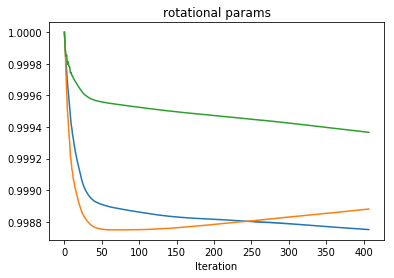

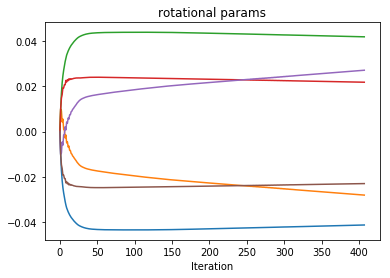

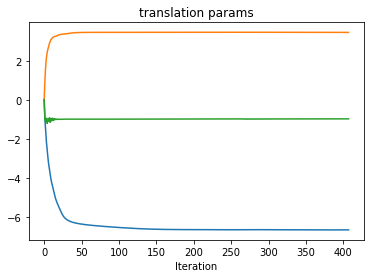

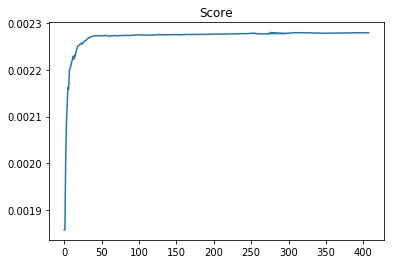

aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV6/atlasV6_10.0um_scoreVolume_Amb_R_warp7_MD661_detector799_10.0um_scoreVolume_Amb/atlasV6_10.0um_scoreVolume_Amb_R_warp7_MD661_detector799_10.0um_scoreVolume_Amb_parameters.json" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV6/atlasV6_10.0um_scoreVolume_Amb_R_warp7_MD661_detector799_10.0um_scoreVolume_Amb/atlasV6_10.0um_scoreVolume_Amb_R_warp7_MD661_detector799_10.0um_scoreVolume_Amb_parameters.json"
return code: 0
aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV6/atlasV6_10.0um_scoreVolume_Amb_R_warp7_MD661_detector799_10.0um_scoreVolume_Amb/atlasV6_10.0um_scoreVolume_Amb_R_warp7_MD661_detector799_10.0um_scoreVolume_Amb_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV6/atlasV6_10.0um_scoreVolume_Amb_R_warp7_MD661_detector799_10.0um_scoreVolume_Amb/atlasV6_10.0um_scoreVolume_Amb_R_warp7_MD661_detector799_10.0um_scoreVolume_Amb_scoreHistory.bp"
return code: 0
aws s3 cp 

In [6]:
# for structure_m in ['Amb_L', 'Amb_R', ('3N_L', '4N_L'), ('3N_R', '4N_R'), '5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', '10N_L', '10N_R', '12N']:

# for stack in ['CHATM2', 'CHATM3']:
for stack in ['MD661']:

#     for structure_m in ['Amb_L', 'Amb_R', ('3N_L', '4N_L'), ('3N_R', '4N_R'), '5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', '10N_L', '10N_R', '12N']:
#     for structure_m in [('3N_L', '4N_L'), ('3N_R', '4N_R')]:
#     for structure_m in [('SC', 'IC')]:
    for structure_m in ['Amb_L', 'Amb_R']:

        is_complex = not isinstance(structure_m, str)

        if is_complex:

            structures_m = structure_m

            stack_m_spec = dict(name='atlasV6',
                               vol_type='score',
                                resolution='10.0um'
                               )

            stack_f_spec = dict(name=stack,
                               vol_type='score',
                               detector_id=detector_id,
                                resolution='10.0um'
                               )

        else:

            structures_m = [structure_m]

            stack_m_spec = dict(name='atlasV6',
                               vol_type='score',
                               structure=structure_m,
                                resolution='10.0um'
                               )

            stack_f_spec = dict(name=stack,
                               vol_ type='score',
                               detector_id=detector_id,
                               structure=convert_to_original_name(structure_m),
                                resolution='10.0um'
                               )

        local_alignment_spec = dict(stack_m=stack_m_spec, 
                              stack_f=stack_f_spec,
                              warp_setting=warp_setting)       

        local_aligner_parameters = generate_aligner_parameters_v2(alignment_spec=local_alignment_spec,
        structures_m=structures_m,
        fixed_structures_are_sided=True,
        fixed_surroundings_have_positive_value=False,
                                                                  fixed_use_surround=False,
        )

        aligner = Aligner(local_aligner_parameters['volume_fixed'], 
                          local_aligner_parameters['volume_moving'], 
                          labelIndexMap_m2f=local_aligner_parameters['label_mapping_m2f'])

        aligner.compute_gradient(smooth_first=True)
        aligner.set_label_weights(label_weights=local_aligner_parameters['label_weights_m'])
        
        T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol = bp.unpack_ndarray_file('/home/yuncong/' + stack_f_spec['name'] + '_T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol.bp')

        aligner.set_initial_transform(transform=T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol)

        if is_complex:
            aligner.set_centroid(centroid_m='volume_centroid', 
                             centroid_f='centroid_m')
        else:
            aligner.set_centroid(
                centroid_m='structure_centroid', 
                                 centroid_f='centroid_m')
#                                 indices_m=[local_aligner_parameters['structure_to_label_moving'][structure_m]])

        if 'SC' in structures_m or 'IC' in structures_m:
            grid_search_iteration_number = 0
        else:
            grid_search_iteration_number = 3
            
        grid_search_T, _ = aligner.do_grid_search(grid_search_iteration_number=grid_search_iteration_number, 
                                                  grid_search_sample_number=10, 
                               std_tx=100, std_ty=100, std_tz=30, 
                               grid_search_eta=3.0, 
                               stop_radius_voxel=10, indices_m=None, parallel=True, 
                               init_T=None)

        init_T = grid_search_T
        aligner.set_initial_transform(init_T)  

        if is_complex:
            aligner.set_centroid(centroid_m='volume_centroid', 
                             centroid_f='centroid_m')
        else:
            aligner.set_centroid(centroid_m='structure_centroid', 
                                 centroid_f='centroid_m')
#                                 indices_m=[local_aligner_parameters['structure_to_label_moving'][structure_m]])
        
        t = time.time()
        _, _ = aligner.optimize(tf_type=local_aligner_parameters['transform_type'], 
#                                 grad_computation_sample_number=10000,
#                                     max_iter_num=100,
                                     max_iter_num=10000,
                                     history_len=100, 
                                     terminate_thresh_trans=.01,
                                    terminate_thresh_rot=.01,
                                     full_lr=np.array([1,1,1,.01,.01,.01]),
        #                         full_lr=np.array([10,10,10,.1,.1,.1]),
                                    )
        sys.stderr.write("Optimize: %.2f seconds.\n" % (time.time() - t))

        plot_alignment_results(traj=aligner.Ts, scores=aligner.scores, select_best='max_value')

        #     tf_atlas_to_subj = compose_alignment_parameters([T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol, 
        #                                                              convert_transform_forms(aligner=aligner, out_form=(3,4))])

        tf_atlas_to_subj = compose_alignment_parameters([init_T, convert_transform_forms(aligner=aligner, out_form=(3,4))])


        for structure_m in structures_m:

            stack_m_spec = dict(name='atlasV6',
                       vol_type='score',
                       structure=structure_m,
                        resolution='10.0um'
                       )

#             stack_f_spec = dict(name=stack,
#                                vol_type='score',
#                                detector_id=detector_id,
#                                structure=convert_to_original_name(structure_m),
#                                 resolution='10.0um'
#                                )

            local_alignment_spec = dict(stack_m=stack_m_spec, 
                                  stack_f=stack_f_spec,
                                  warp_setting=warp_setting)

#             DataManager.save_alignment_results_v3(transform_parameters=convert_transform_forms(transform=tf_atlas_to_subj, out_form='dict'),
#                            score_traj=aligner.scores,
#                            parameter_traj=aligner.Ts,
#                           alignment_spec=local_alignment_spec)

#             tf_atlas_to_subj = DataManager.load_alignment_results_v3(local_alignment_spec, what='parameters', out_form=(4,4))

            atlas_structure_wrt_canonicalAtlasSpace_atlasResol = \
            DataManager.load_original_volume_v2(stack_spec=stack_m_spec, bbox_wrt='canonicalAtlasSpace', structure=structure_m)

            aligned_structure_wrt_wholebrain_inputResol = \
            transform_volume_v4(volume=atlas_structure_wrt_canonicalAtlasSpace_atlasResol,
                                transform=tf_atlas_to_subj,
                                return_origin_instead_of_bbox=True)

            DataManager.save_transformed_volume_v2(volume=aligned_structure_wrt_wholebrain_inputResol, 
                                                   alignment_spec=local_alignment_spec,
                                                  structure=structure_m)
            
            
            ###########################################################################################
            
            stack_m_spec = dict(name='atlasV6',
                       vol_type='score',
                       structure=structure_m,
                        resolution='10.0um'
                       )

            stack_f_spec = dict(name=stack,
                               vol_type='score',
                               detector_id=detector_id,
                               structure=convert_to_original_name(structure_m),
                                resolution='10.0um'
                               )

            simpleGlobal_alignment_spec = dict(stack_m=stack_m_spec, 
                                  stack_f=stack_f_spec,
                                  warp_setting=0)

            atlas_structure_wrt_canonicalAtlasSpace_atlasResol = \
            DataManager.load_original_volume_v2(stack_spec=stack_m_spec, bbox_wrt='canonicalAtlasSpace', structure=structure_m)

            aligned_structure_wrt_wholebrain_inputResol = \
            transform_volume_v4(volume=atlas_structure_wrt_canonicalAtlasSpace_atlasResol,
                                transform=init_T,
                                return_origin_instead_of_bbox=True)

            DataManager.save_transformed_volume_v2(volume=aligned_structure_wrt_wholebrain_inputResol, 
                                                   alignment_spec=simpleGlobal_alignment_spec)

# Visualize

In [67]:
def get_structure_contours_from_structure_volumes_v3(volumes, stack, sections, 
                                                     resolution, level, sample_every=1,
                                                    use_unsided_name_as_key=False):
    """
    Re-section atlas volumes and obtain structure contours on each section.
    Resolution of output contours are in volume resolution.
    v3 supports multiple levels.

    Args:
        volumes (dict of (3D array, 3-tuple)): {structure: (volume, origin_wrt_wholebrain)}. volume is a 3d array of probability values.
        sections (list of int):
        resolution (int): resolution of input volumes.
        level (float or dict or dict of list): the cut-off probability at which surfaces are generated from probabilistic volumes. Default is 0.5.
        sample_every (int): how sparse to sample contour vertices.

    Returns:
        Dict {section: {name_s: contour vertices}}.
    """

    from collections import defaultdict
    
    structure_contours_wrt_alignedBrainstemCrop_rawResol = defaultdict(lambda: defaultdict(dict))

    converter = CoordinatesConverter(stack=stack, section_list=metadata_cache['sections_to_filenames'][stack].keys())

    converter.register_new_resolution('structure_volume', resol_um=convert_resolution_string_to_um(resolution=resolution, stack=stack))
    converter.register_new_resolution('image', resol_um=convert_resolution_string_to_um(resolution='raw', stack=stack))
    
    for name_s, (structure_volume_volResol, origin_wrt_wholebrain_volResol) in volumes.iteritems():

        converter.derive_three_view_frames(name_s, 
        origin_wrt_wholebrain_um=convert_resolution_string_to_um(resolution=resolution, stack=stack) * origin_wrt_wholebrain_volResol,
        zdim_um=convert_resolution_string_to_um(resolution=resolution, stack=stack) * structure_volume_volResol.shape[2])

        positions_of_all_sections_wrt_structureVolume = converter.convert_frame_and_resolution(
        p=np.array(sections)[:,None],
        in_wrt=('wholebrain', 'sagittal'), in_resolution='section',
        out_wrt=(name_s, 'sagittal'), out_resolution='structure_volume')[..., 2].flatten()
            
        structure_ddim = structure_volume_volResol.shape[2]
        
        valid_mask = (positions_of_all_sections_wrt_structureVolume >= 0) & (positions_of_all_sections_wrt_structureVolume < structure_ddim)
        if np.count_nonzero(valid_mask) == 0:
#             sys.stderr.write("%s, valid_mask is empty.\n" % name_s)
            continue

        positions_of_all_sections_wrt_structureVolume = positions_of_all_sections_wrt_structureVolume[valid_mask]
        positions_of_all_sections_wrt_structureVolume = np.round(positions_of_all_sections_wrt_structureVolume).astype(np.int)
        
        if isinstance(level, dict):
            level_this_structure = level[name_s]
        else:
            level_this_structure = level

        if isinstance(level_this_structure, float):
            level_this_structure = [level_this_structure]
                        
        for one_level in level_this_structure:

            contour_2d_wrt_structureVolume_sectionPositions_volResol = \
            find_contour_points_3d(structure_volume_volResol >= one_level,
                                    along_direction='sagittal',
                                    sample_every=sample_every,
                                    positions=positions_of_all_sections_wrt_structureVolume)

            for d_wrt_structureVolume, cnt_uv_wrt_structureVolume in contour_2d_wrt_structureVolume_sectionPositions_volResol.iteritems():

                contour_3d_wrt_structureVolume_volResol = np.column_stack([cnt_uv_wrt_structureVolume, np.ones((len(cnt_uv_wrt_structureVolume),)) * d_wrt_structureVolume])

    #             contour_3d_wrt_wholebrain_uv_rawResol_section = converter.convert_frame_and_resolution(
    #                 p=contour_3d_wrt_structureVolume_volResol,
    #                 in_wrt=(name_s, 'sagittal'), in_resolution='structure_volume',
    #                 out_wrt=('wholebrain', 'sagittal'), out_resolution='image_image_section')

                contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section = converter.convert_frame_and_resolution(
                    p=contour_3d_wrt_structureVolume_volResol,
                    in_wrt=(name_s, 'sagittal'), in_resolution='structure_volume',
                    out_wrt=('wholebrainXYcropped', 'sagittal'), out_resolution='image_image_section')

                assert len(np.unique(contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section[:,2])) == 1
                sec = int(contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section[0,2])

                if use_unsided_name_as_key:
                    name = convert_to_unsided_label(name_s)
                else:
                    name = name_s

                structure_contours_wrt_alignedBrainstemCrop_rawResol[sec][name][one_level] = contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section[..., :2]
        
    return structure_contours_wrt_alignedBrainstemCrop_rawResol

In [68]:
detector_id = 799
# detector_id = 19

In [69]:
stack_m_spec = dict(name='atlasV6',
                   vol_type='score',
                    structure=['3N_L','4N_L'],
                    resolution='10.0um'
                   )

stack_f_spec = dict(name=stack,
                   vol_type='score',
                   detector_id=detector_id,
                    structure=['3N','4N'],
                    resolution='10.0um'
                   )

In [70]:
simpleGlobal_alignment_spec = dict(stack_m=stack_m_spec, 
                      stack_f=stack_f_spec,
                      warp_setting=0)

In [71]:
local_alignment_spec = dict(stack_m=stack_m_spec, 
                      stack_f=stack_f_spec,
                      warp_setting=warp_setting)

In [72]:
# for stack in ['CHATM2', 'CHATM3']:
# for stack in ['CHATM2']:
for stack in ['MD661']:

    section_margin_um = 1000.
    section_margin = int(section_margin_um / SECTION_THICKNESS)

    valid_secmin = np.min(metadata_cache['valid_sections'][stack])
    valid_secmax = np.max(metadata_cache['valid_sections'][stack])

    auto_contours_all_sec_all_structures_all_levels = defaultdict(lambda: defaultdict(dict))
    
    #######################
    
#     chat_structures_df = DataManager.load_annotation_v4(stack=stack, by_human=True, 
#                                                    suffix='structuresHanddrawn', 
#                                                    timestamp='latest')

#     chat_structures_df = chat_structures_df[~chat_structures_df['volume'].isnull()]

#     chat_structures, chat_structure_resolution = \
#     convert_structure_annotation_to_volume_origin_dict_v2(structures_df=chat_structures_df, 
#                                                           out_resolution='10.0um', stack=stack)

    ########################
    
#     for structure_m in ['Amb_L', 'Amb_R','3N_L','3N_R','4N_L','4N_R',  '6N_L', '6N_R', '5N_L', '5N_R', '7N_L', '7N_R', '10N_L', '10N_R', '12N']:
#     for structure_m in ['Amb_L', 'Amb_R']:
    for structure_m in ['3N_L', '4N_L']:
#     for structure_m in ['SC']:
    
        ####################################################
    
#         brain_m_spec = dict(name='atlasV6',
#                            vol_type='score',
#                            structure=structure_m,
#                             resolution='10.0um'
#                            )

#         brain_f_spec = dict(name=stack,
#                            vol_type='score',
#                            detector_id=detector_id,
#                            structure=convert_to_original_name(structure_m),
#                             resolution='10.0um'
#                            
        vo = DataManager.load_transformed_volume_v2(alignment_spec=local_alignment_spec, 
                                                    return_origin_instead_of_bbox=True,
                                                   structure=structure_m)

        registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners = \
        load_json('/home/yuncong/' + stack + '_registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners.json')

        (_, _, secmin), (_, _, secmax) = registered_atlas_structures_wrt_wholebrainXYcropped_xysecTwoCorners[structure_m]

        atlas_structures_wrt_wholebrainWithMargin_sections = \
        range(max(secmin - section_margin, valid_secmin), min(secmax + 1 + section_margin, valid_secmax))

        levels = [0.1, 0.25, 0.5, 0.75, 0.99]

        contours_all_sections_all_structures_all_levels = \
        get_structure_contours_from_structure_volumes_v3(volumes={structure_m: vo}, stack=stack, 
                                                         sections=atlas_structures_wrt_wholebrainWithMargin_sections,
                                                        resolution='10.0um', level=levels, sample_every=5)

        ####################################################
        

        simpleGlobal_vo = DataManager.load_transformed_volume_v2(alignment_spec=simpleGlobal_alignment_spec, 
                                                                 return_origin_instead_of_bbox=True,
                                                                structure=structure_m)

        simpleGlobal_contours_all_sections_all_structures_all_levels = \
        get_structure_contours_from_structure_volumes_v3(volumes={structure_m: simpleGlobal_vo}, stack=stack, 
                                                         sections=atlas_structures_wrt_wholebrainWithMargin_sections,
                                                        resolution='10.0um', level=levels, sample_every=5)

        ####################################

#         chat_vo = chat_structures[structure_m]

#         chat_contours_all_sections_all_structures_all_levels = \
#         get_structure_contours_from_structure_volumes_v3(volumes={structure_m: chat_vo}, stack=stack, 
#                                                          sections=atlas_structures_wrt_wholebrainWithMargin_sections,
#                                                         resolution='10.0um', level=[.5], sample_every=1)

        ####################################

        # prep2 because at end of get_structure_contours_from_structure_volumes_v2 we used wholebrainXYcropped

        for sec, contours_all_structures_all_levels in sorted(contours_all_sections_all_structures_all_levels.items()):

            if is_invalid(sec=sec, stack=stack):
                continue

            for name_s, cnt_all_levels in contours_all_structures_all_levels.iteritems():
                for level, cnt in cnt_all_levels.iteritems():
                    auto_contours_all_sec_all_structures_all_levels[sec][name_s][level] = cnt.astype(np.int)

    #######################################

    for sec, contours_all_structures_all_levels in sorted(auto_contours_all_sec_all_structures_all_levels.items()):

        if is_invalid(sec=sec, stack=stack):
            continue
            
        for version in ['NtbNormalizedAdaptiveInvertedGammaJpeg']:
#         for version in ['grayJpeg']:
#         for version in ['NtbNormalizedAdaptiveInvertedGammaJpeg', 'CHATJpeg']:

            img = DataManager.load_image_v2(stack=stack, prep_id=2, resol='raw', version=version, section=sec)
            viz = gray2rgb(img)

            for name_s, cnt_all_levels in contours_all_structures_all_levels.iteritems():

                for level, cnt in cnt_all_levels.iteritems():
                    cv2.polylines(viz, [cnt.astype(np.int)], isClosed=True, 
                                  color=LEVEL_TO_COLOR_LINE[level], thickness=10)
                    
            for name_s, cnt_all_levels in simpleGlobal_contours_all_sections_all_structures_all_levels[sec].iteritems():

                for level, cnt in cnt_all_levels.iteritems():
                    cv2.polylines(viz, [cnt.astype(np.int)], isClosed=True, 
                                  color=(255,255,255), 
                                  thickness=10)

# #             # Add CHAT contour
#             if sec in chat_contours_all_sections_all_structures_all_levels:
#                 chat_cnt = chat_contours_all_sections_all_structures_all_levels[sec][name_s][.5]
#                 cv2.polylines(viz, [chat_cnt.astype(np.int)], isClosed=True, color=(255,255,255), thickness=20)
                    
#             fp = os.path.join('/home/yuncong/' + stack + '_atlas_aligned_multilevel_all_structures', version, stack + '_' + version + '_' + ('%03d' % sec) + '.jpg')
#             print fp
#             create_parent_dir_if_not_exists(fp)
#             imsave(fp, viz)

            fp = os.path.join('/home/yuncong/' + stack + '_atlas_aligned_multilevel_down16_all_structures', version, stack + '_' + version + '_' + ('%03d' % sec) + '.jpg')
            print fp
            create_parent_dir_if_not_exists(fp)
            imsave(fp, viz[::16, ::16])

2 contours of reconstructed volume is found at position 3 ([13, 4]). Use the longest one.
contour has less than three vertices. Ignore.
Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F69-2017.06.06-08.11.04_MD661_2_0206_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
/home/yuncong/MD661_atlas_aligned_multilevel_down16_all_structures/NtbNormalizedAdaptiveInvertedGammaJpeg/MD661_NtbNormalizedAdaptiveInvertedGammaJpeg_203.jpg


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F70-2017.06.06-08.36.23_MD661_1_0208_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
/home/yuncong/MD661_atlas_aligned_multilevel_down16_all_structures/NtbNormalizedAdaptiveInvertedGammaJpeg/MD661_NtbNormalizedAdaptiveInvertedGammaJpeg_204.jpg


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F70-2017.06.06-08.36.23_MD661_2_0209_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
/home/yuncong/MD661_atlas_aligned_multilevel_down16_all_structures/NtbNormalizedAdaptiveInvertedGammaJpeg/MD661_NtbNormalizedAdaptiveInvertedGammaJpeg_205.jpg


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F71-2017.06.06-09.00.35_MD661_1_0211_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
/home/yuncong/MD661_atlas_aligned_multilevel_down16_all_structures/NtbNormalizedAdaptiveInvertedGammaJpeg/MD661_NtbNormalizedAdaptiveInvertedGammaJpeg_206.jpg


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F71-2017.06.06-09.00.35_MD661_2_0212_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
/home/yuncong/MD661_atlas_aligned_multilevel_down16_all_structures/NtbNormalizedAdaptiveInvertedGammaJpeg/MD661_NtbNormalizedAdaptiveInvertedGammaJpeg_207.jpg


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F72-2017.06.06-09.26.44_MD661_1_0214_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
/home/yuncong/MD661_atlas_aligned_multilevel_down16_all_structures/NtbNormalizedAdaptiveInvertedGammaJpeg/MD661_NtbNormalizedAdaptiveInvertedGammaJpeg_208.jpg


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F72-2017.06.06-09.26.44_MD661_2_0215_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
/home/yuncong/MD661_atlas_aligned_multilevel_down16_all_structures/NtbNormalizedAdaptiveInvertedGammaJpeg/MD661_NtbNormalizedAdaptiveInvertedGammaJpeg_209.jpg


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F73-2017.06.06-09.53.20_MD661_1_0217_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
/home/yuncong/MD661_atlas_aligned_multilevel_down16_all_structures/NtbNormalizedAdaptiveInvertedGammaJpeg/MD661_NtbNormalizedAdaptiveInvertedGammaJpeg_210.jpg


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F73-2017.06.06-09.53.20_MD661_2_0218_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
/home/yuncong/MD661_atlas_aligned_multilevel_down16_all_structures/NtbNormalizedAdaptiveInvertedGammaJpeg/MD661_NtbNormalizedAdaptiveInvertedGammaJpeg_211.jpg


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F75-2017.06.06-10.19.15_MD661_1_0223_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
/home/yuncong/MD661_atlas_aligned_multilevel_down16_all_structures/NtbNormalizedAdaptiveInvertedGammaJpeg/MD661_NtbNormalizedAdaptiveInvertedGammaJpeg_212.jpg


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F75-2017.06.06-10.19.15_MD661_2_0224_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
/home/yuncong/MD661_atlas_aligned_multilevel_down16_all_structures/NtbNormalizedAdaptiveInvertedGammaJpeg/MD661_NtbNormalizedAdaptiveInvertedGammaJpeg_213.jpg


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F76-2017.06.06-16.23.52_MD661_1_0226_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
/home/yuncong/MD661_atlas_aligned_multilevel_down16_all_structures/NtbNormalizedAdaptiveInvertedGammaJpeg/MD661_NtbNormalizedAdaptiveInvertedGammaJpeg_214.jpg


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
/home/yuncong/MD661_atlas_aligned_multilevel_down16_all_structures/NtbNormalizedAdaptiveInvertedGammaJpeg/MD661_NtbNormalizedAdaptiveInvertedGammaJpeg_215.jpg


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F77-2017.06.06-11.00.56_MD661_1_0229_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
/home/yuncong/MD661_atlas_aligned_multilevel_down16_all_structures/NtbNormalizedAdaptiveInvertedGammaJpeg/MD661_NtbNormalizedAdaptiveInvertedGammaJpeg_216.jpg


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F77-2017.06.06-11.00.56_MD661_2_0230_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
/home/yuncong/MD661_atlas_aligned_multilevel_down16_all_structures/NtbNormalizedAdaptiveInvertedGammaJpeg/MD661_NtbNormalizedAdaptiveInvertedGammaJpeg_217.jpg


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F78-2017.06.06-11.26.03_MD661_1_0232_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
/home/yuncong/MD661_atlas_aligned_multilevel_down16_all_structures/NtbNormalizedAdaptiveInvertedGammaJpeg/MD661_NtbNormalizedAdaptiveInvertedGammaJpeg_218.jpg


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F78-2017.06.06-11.26.03_MD661_2_0233_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
/home/yuncong/MD661_atlas_aligned_multilevel_down16_all_structures/NtbNormalizedAdaptiveInvertedGammaJpeg/MD661_NtbNormalizedAdaptiveInvertedGammaJpeg_219.jpg


Not using image_cache.


/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F79-2017.06.06-11.52.28_MD661_1_0235_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg
/home/yuncong/MD661_atlas_aligned_multilevel_down16_all_structures/NtbNormalizedAdaptiveInvertedGammaJpeg/MD661_NtbNormalizedAdaptiveInvertedGammaJpeg_220.jpg


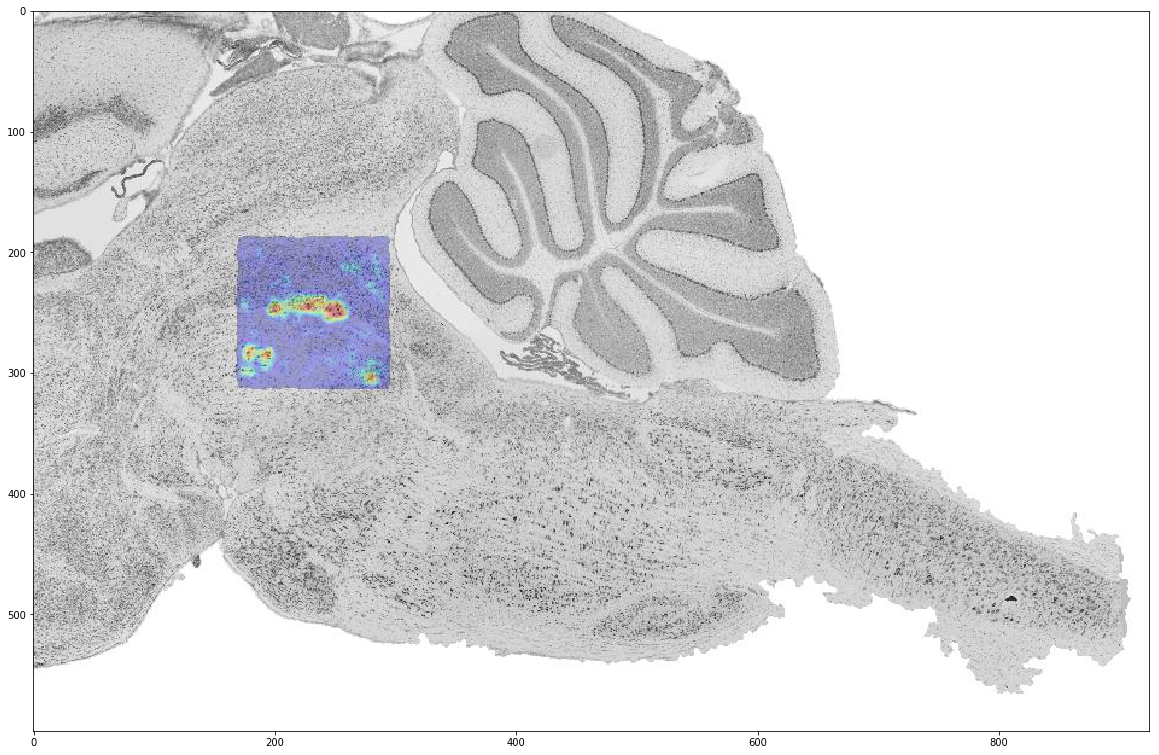

In [28]:
viz = DataManager.load_scoremap_viz_v2(stack='MD593', structure='4N', detector_id=799,  out_resolution='10.0um',
                                     section=191)

plt.figure(figsize=(20,20));
plt.imshow(viz);

# Score history

In [14]:
detector_id = 15

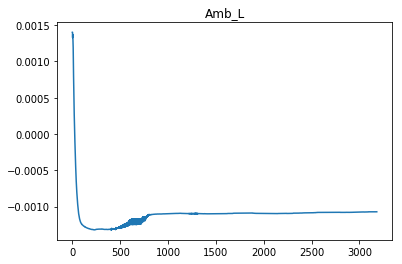

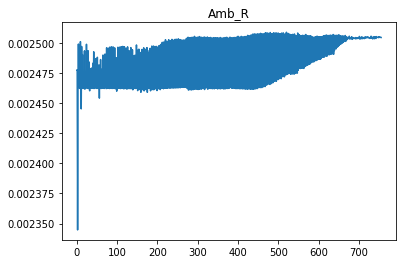

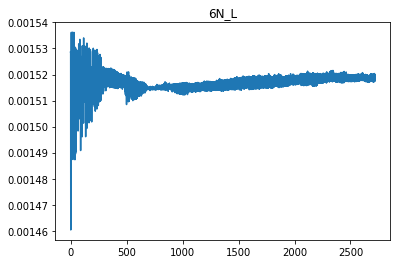

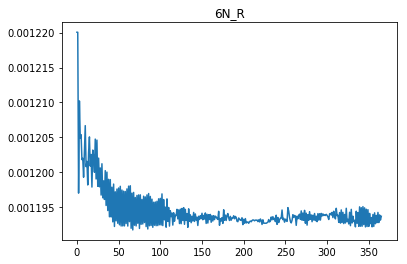

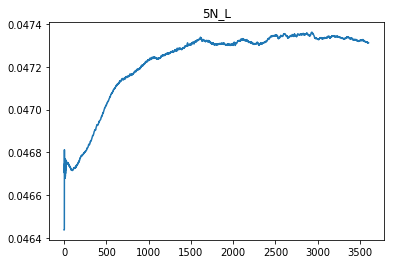

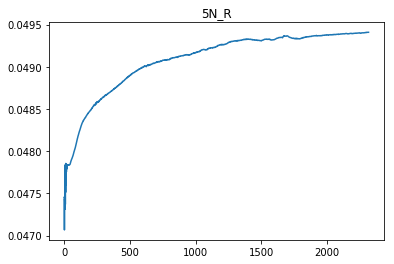

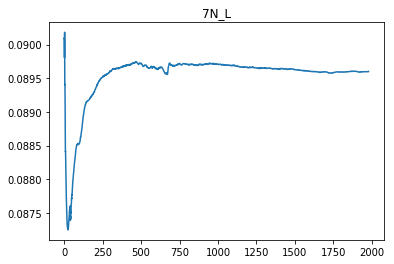

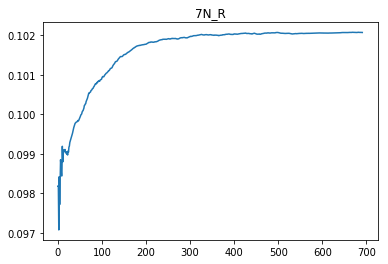

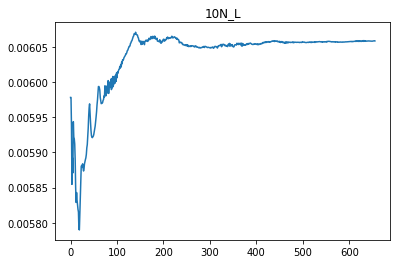

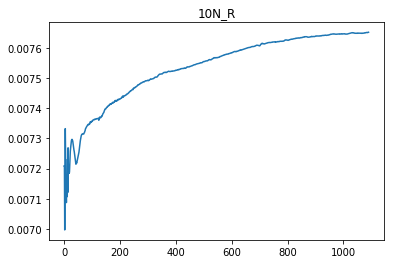

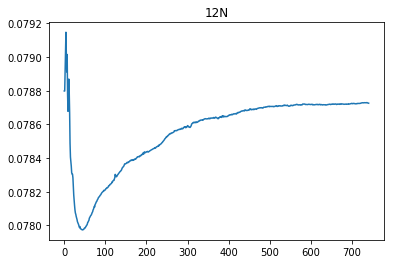

In [15]:
# for structure_m in ['3N_L', '3N_R', '4N_L', '4N_R', '5N_L', '5N_R', '7N_L', '7N_R', '10N_L', '10N_R', '12N']:
for structure_m in ['Amb_L', 'Amb_R', '6N_L', '6N_R', '5N_L', '5N_R', '7N_L', '7N_R', '10N_L', '10N_R', '12N']:


    stack_m_spec = dict(name='atlasV6',
                       vol_type='score',
                       structure=structure_m,
                        resolution='10.0um'
                       )

    stack_f_spec = dict(name=stack,
                       vol_type='score',
                       detector_id=detector_id,
                       structure=convert_to_original_name(structure_m),
                        resolution='10.0um'
                       )

    local_alignment_spec = dict(stack_m=stack_m_spec, 
                          stack_f=stack_f_spec,
                          warp_setting=27)

    scores = DataManager.load_alignment_results_v3(local_alignment_spec, what='scoreHistory')
    
#     plt.figure(figsize=(20,10));
    plt.figure();
    plt.plot(scores);
    plt.title(structure_m);
    plt.show();